# Uncertainty for a Synthetic Regression Task using probly

This notebook gives an example for quantifying uncertainty in a synthetic regression setting using the setup from Valdenegro-Toro et al. (2022). Paper: https://arxiv.org/abs/2204.09308

In [231]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

### Generate Synthetic Data
Generate a synthetic data set based on a sinusoidal function. Sample data points (x) uniformly between 0 and 10 and generate labels based on the function. Create training data, test data and out of distribution data (x between 10 and 15).

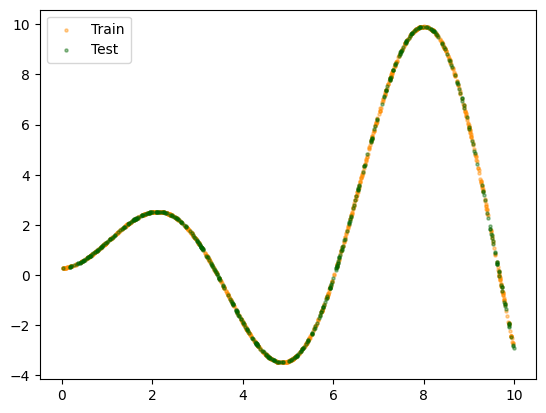

In [275]:
eps1 = np.random.normal(0, 0.5)
eps2 = np.random.normal(0, 0.5)

# Generate data points between 0 and 10
X = np.expand_dims(np.random.uniform(0, 10, 1500), axis=1)
X_train = X[:1000]
X_test = X[1000:]
# Generate ood data points between 10 and 15
X_ood = np.expand_dims(np.random.uniform(10, 15, 200), axis=1)

# Generate labels
y = X * np.sin(X) + eps1 * X + eps2         # TODO check aleatoric
y_train = y[:1000, 0]
y_test = y[1000:, 0]

# Sort test samples for easy plotting
id_test = np.argsort(X_test[:, 0]) 
id_ood = np.argsort(X_ood[:, 0])
X_test, y_test, X_ood = X_test[id_test], y_test[id_test], X_ood[id_ood]

# create data loaders
batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)

# plot data
plt.scatter(X_train[:, 0], y_train, c='darkorange', s=5, alpha=0.4, label='Train')
plt.scatter(X_test[:, 0], y_test, c='darkgreen', s=5, alpha=0.4, label='Test')
plt.legend()
plt.show()

### Create Dropout Model
Create a simple neural network and transform it to a Dropout model using probly.

In [233]:
from probly.representation.dropout import Dropout

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc31 = nn.Linear(32, 1)
        self.fc32 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc31(x)
        sigma2 = F.softplus(self.fc32(x))
        x = torch.cat([mu, sigma2], dim=1)
        return x

net = Net()
# transform model to a Dropout model
model = Dropout(net, p=0.25)
optimizer = optim.Adam(model.parameters())#, lr=0.001)
#criterion = nn.GaussianNLLLoss()

class GaussianNLL(nn.Module):
    def __init__(self):
        super(GaussianNLL, self).__init__()
    def forward(self, mu, sigma2, y):
        return 0.5 * torch.mean(torch.log(sigma2) + (y - mu) ** 2 / sigma2)
    
criterion = GaussianNLL()

### Train Dropout Model
Train the Dropout model based on the training data, the given loss (criterion) and optimizer.

In [234]:
epochs = 700

pbar = tqdm(range(epochs), desc="Training", unit="epoch")
for _ in pbar:
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, 1)
        mean = outputs[:, 0, 0]
        var = outputs[:, 0, 1]
        loss = criterion(mean, var, targets)
        loss.backward()
        optimizer.step()
    pbar.set_description(desc=f"Loss: {loss:.4f} Progress")
model.eval()

Loss: 0.7381 Progress: 100%|██████████| 700/700 [00:10<00:00, 67.29epoch/s] 


### Evaluation
Evaluate model performance and uncertainty behavior for the test and ood data points.

MSE: 4.84


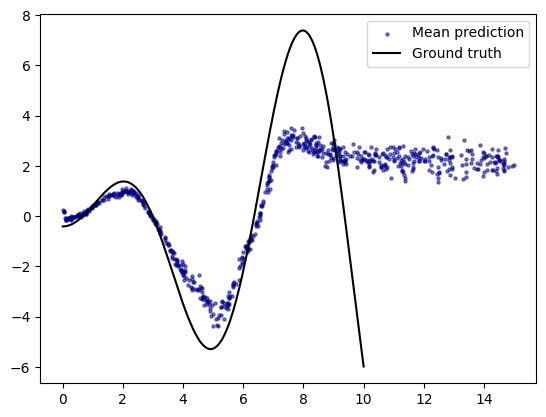

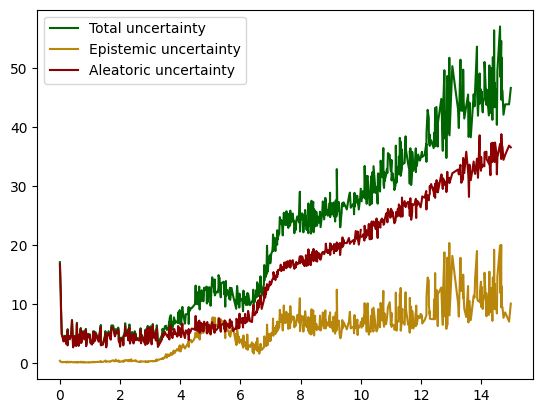

In [270]:
from probly.quantification.regression import total_uncertainty_variance, aleatoric_uncertainty_variance, epistemic_uncertainty_variance

# generate prediction
y_pred = model(torch.from_numpy(X_test).float(), 100).detach().cpu().numpy()
y_pred_ood = model(torch.from_numpy(X_ood).float(), 100).detach().cpu().numpy()

# evaluate model performance
mse = ((y_pred.mean(axis=1)[:, 0] - y_test)**2).mean()
print(f'MSE: {mse:.2f}')

# evaluate uncertainty
tu = total_uncertainty_variance(y_pred)
au = aleatoric_uncertainty_variance(y_pred)
eu = epistemic_uncertainty_variance(y_pred)
tu_ood = total_uncertainty_variance(y_pred_ood)
au_ood = aleatoric_uncertainty_variance(y_pred_ood)
eu_ood = epistemic_uncertainty_variance(y_pred_ood)

# plot results
plt.scatter(X_test, y_pred.mean(axis=1)[:, 0], s=5, label='Mean prediction', c='darkblue', alpha=0.5)
plt.scatter(X_ood, y_pred_ood.mean(axis=1)[:, 0], s=5, c='darkblue', alpha=0.5)
plt.plot(X_test, y_test, label='Ground truth', c='k')
plt.legend()
plt.show()

plt.plot(X_test, tu, label='Total uncertainty', c='darkgreen')
plt.plot(X_test, eu, label='Epistemic uncertainty', c='darkgoldenrod')
plt.plot(X_test, au, label='Aleatoric uncertainty', c='darkred')
plt.plot(X_ood, tu_ood, c='darkgreen')
plt.plot(X_ood, eu_ood, c='darkgoldenrod')
plt.plot(X_ood, au_ood, c='darkred')
plt.legend()
plt.show()

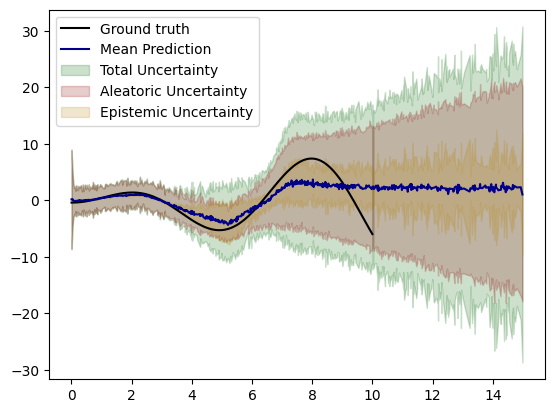

In [268]:
plt.plot(X_test, y_test, label='Ground truth', c='k')
plt.plot(X_test, y_pred.mean(axis=1)[:, 0], c='darkblue')
plt.plot(X_ood, y_pred_ood.mean(axis=1)[:, 0], c='darkblue', label='Mean Prediction')
plt.fill_between(X_test[:, 0], y_pred.mean(axis=1)[:, 0]-(tu/2), y_pred.mean(axis=1)[:, 0]+(tu/2), alpha=0.2, color='darkgreen', label='Total Uncertainty')
plt.fill_between(X_test[:, 0], y_pred.mean(axis=1)[:, 0]-(au/2), y_pred.mean(axis=1)[:, 0]+(au/2), alpha=0.2, color='darkred', label='Aleatoric Uncertainty')
plt.fill_between(X_test[:, 0], y_pred.mean(axis=1)[:, 0]-(eu/2), y_pred.mean(axis=1)[:, 0]+(eu/2), alpha=0.2, color='darkgoldenrod', label='Epistemic Uncertainty')
plt.fill_between(X_ood[:, 0], y_pred_ood.mean(axis=1)[:, 0]-(tu_ood/2), y_pred_ood.mean(axis=1)[:, 0]+(tu_ood/2), alpha=0.2, color='darkgreen')
plt.fill_between(X_ood[:, 0], y_pred_ood.mean(axis=1)[:, 0]-(au_ood/2), y_pred_ood.mean(axis=1)[:, 0]+(au_ood/2), alpha=0.2, color='darkred')
plt.fill_between(X_ood[:, 0], y_pred_ood.mean(axis=1)[:, 0]-(eu_ood/2), y_pred_ood.mean(axis=1)[:, 0]+(eu_ood/2), alpha=0.2, color='darkgoldenrod')
plt.legend()
plt.show()